In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ravdess-emotional-speech-audio:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F107620%2F256618%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240616%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240616T042511Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4985892b3901843ab39edc8467e874ee0bbc1106941f964b0b216636caf60111ae126db5f8aa74b38050e6981ddce454a93c6d83baeca3b7321354ddddf21d1863d05f8f9932edd63f7c3ab388bc0a0e57959b9100da0edf45a87f38fa0897bcfe3c44318fd940ccc2d2f6eb134130679136e0885635631d801425ab48b26826a2a05cca3b5d589b289b036f9f67c4dd0ec4c1063135563fb008a693e65bd96e683bbd10d58116a2fa8cda8bdc2e6ba34ed2b309651caf83e993bfdcfc5bb403bc4c5861f845bff31946bafc94fa3f4b6ee849ba295ace5c6c107933d855c46a6e2b451d7b0291bd940976c62b5d77b54991c9fdb0ab73b7ba5c2c58139acad0,toronto-emotional-speech-set-tess:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F316368%2F639622%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240616%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240616T042511Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8035fa5be32a23607e5fb953ccf0b37276d3cf106a9e9369e0bf6c24c8af081c643d79f0ff826eaea36d03932166bc8ff4ef20003d809b84c5f0712f2cc74c2a89f4b683d8e4ec5a276b6a091b1b3018ad4265eee199ae3cd79e4f976b4b01c8b695b61d37884da335c8feba2aa10e4f565865c061513ceb7252385d57945ba3ab0fb98448f8a77ced5eb4a920f64817b1a5368be4e8158f8307a08331a9588d28d90adf53f29797a3433408925c42f54b9ede476a612f3400107daa7652457ae50053b51aa1da90291a6c2787093a856ea38084e9757a47f71cd0e0a93c1d00c27d282c2cad0fa0950e336914d4396973d93c6c268e57dc38b8bc766370211d,cremad:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F325566%2F653195%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240616%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240616T042512Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2759ed2ca0ce2cf4f888f1eb1d602178a44890393ea828d42122ed5a88a6b39a975b2e51628eb03064e12e688a10484c0cfd78a253ec2dcb7aa27ec1ccdc5d49d2f00eb62e03009878133a8e1b026085f019b51d19bbe116fedfa2ae625342f5f21bda38fffe9cfc38fee31ea9eb4e0dff0f820b54a3e2708e62dbb5f23a7aa5ba569daf27271943d6ed0029f8e8d5c45bfc4125d935809cddd0e1358ba8fed7b0cea885c93fa5d4721acbb26e50f112c13e67a4c542f673b2e0c9eba932b596335211cf7deed56443615915132864ae35229df32ad729bcc05246459b1e321603aae1cafe042f6fa9d37b269eb6f925adb75077ba6dd465725122b695e5b803,surrey-audiovisual-expressed-emotion-savee:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F338555%2F671851%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240616%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240616T042512Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D363af571c3f70cef27158a1c86c6981b578584e3fc10282de1586ce359963e30319330dcb2b2eee9ae9a55454d4027e92f2e4b854dc9e57354dd47b64bf3cb5fa495db2f19a89831e41ccf7840d760b86400e94698b686b8b1e6834746ca7e05493359e30cba0074226e4fa19892d19ae19be38cf7e8fe3f4aa78d0945a16b6a29b98dab4b93d953a4c5b8fdd73ddc4df5981a45705efc2d09b1333cc5b858de16a631e3e21ac4b2c145d4e476080943c265d55fbcf05b6007d01c89372bbe511ca750dec49fb4ca36276d4851be7fe98f231b010ee746ea347a88927bab6252d18b781a2300aa2bb8031e381d085b4a0ab503897e8ee7b302c255da4d93deed'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 450102890 bytes downloaded
Downloaded and uncompressed: ravdess-emotional-speech-audio
[==================================================] 448572034 bytes downloaded
Downloaded and uncompressed: toronto-emotional-speech-set-tess
[==================================================] 473324524 bytes downloaded
Downloaded and uncompressed: cremad
[==================================================] 112690765 bytes downloaded
Downloaded and uncompressed: surrey-audiovisual-expressed-emotion-savee
Data source import complete.


In [ ]:
!pip install tensorflow
import tensorflow as tf

!pip install librosa
import librosa
import librosa.display

import numpy as np

import matplotlib.pyplot as plt

!pip install tensorflow-addons
import tensorflow_addons as tfa





     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 5.0 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
import librosa
import librosa.display

In [ ]:
# to play the audio files
from IPython.display import Audio

Total number of audio files: 7442
Categories found: ANG, DIS, FEA, HAP, NEU, SAD
Number of ANG files: 1271
Number of DIS files: 1271
Number of FEA files: 1271
Number of HAP files: 1271
Number of NEU files: 1087
Number of SAD files: 1271


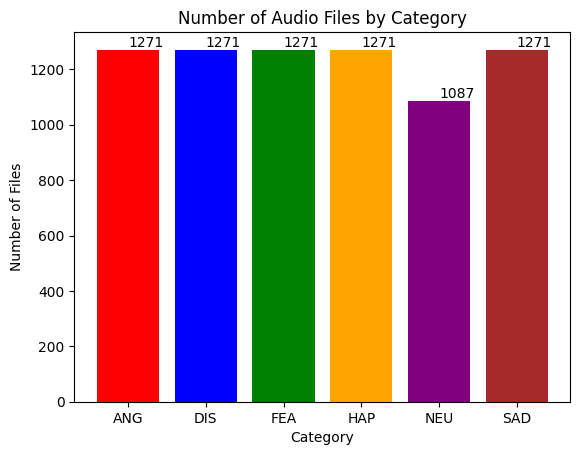

In [ ]:
import os
import matplotlib.pyplot as plt

# Path to your dataset
dataset_path = '/kaggle/input/cremad/AudioWAV/'

# Initialize total count and a set for categories
total_count = 0
categories_set = set()

# Iterate through the files to get total count and extract categories
for filename in os.listdir(dataset_path):
    if filename.endswith('.wav'):
        total_count += 1
        # Extract the label from the filename
        label = filename.split('_')[2]
        categories_set.add(label)

# Convert set to sorted list for consistency
categories = sorted(list(categories_set))

# Initialize dictionary to store the count of each category
data_counts = {category: 0 for category in categories}

# Iterate through the files again to count each category
for filename in os.listdir(dataset_path):
    if filename.endswith('.wav'):
        # Extract the label from the filename
        label = filename.split('_')[2]
        if label in data_counts:
            data_counts[label] += 1

# Print the total number of files and categories
print(f"Total number of audio files: {total_count}")
print(f"Categories found: {', '.join(categories)}")

# Print the number of files for each category
for category, count in data_counts.items():
    print(f"Number of {category} files: {count}")

# Plot the data
fig, ax = plt.subplots()
bars = ax.bar(data_counts.keys(), data_counts.values(), color=['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta'])

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom')

# Add title and labels
ax.set_title('Number of Audio Files by Category')
ax.set_xlabel('Category')
ax.set_ylabel('Number of Files')

# Show the plot
plt.show()


In [ ]:
import os
import pandas as pd

# Path to your dataset
dataset_path = '/kaggle/input/cremad/AudioWAV/'

# Initialize a list to store file paths and labels
data = []

# Iterate through the files to get file paths and labels
for filename in os.listdir(dataset_path):
    if filename.endswith('.wav'):
        parts = filename.split('_')
        if parts[2] == 'SAD':
            label = 'sad'
        elif parts[2] == 'ANG':
            label = 'angry'
        elif parts[2] == 'DIS':
            label = 'disgust'
        elif parts[2] == 'FEA':
            label = 'fear'
        elif parts[2] == 'HAP':
            label = 'happy'
        elif parts[2] == 'NEU':
            label = 'neutral'
        else:
            label = 'Unknown'
        file_path = os.path.join(dataset_path, filename)
        data.append((label, file_path))

# Create a DataFrame
df = pd.DataFrame(data, columns=['Label', 'FilePath'])

# Display the DataFrame
print(df)


        Label                                           FilePath
0         sad  /kaggle/input/cremad/AudioWAV/1039_ITS_SAD_XX.wav
1        fear  /kaggle/input/cremad/AudioWAV/1070_TAI_FEA_XX.wav
2        fear  /kaggle/input/cremad/AudioWAV/1019_WSI_FEA_XX.wav
3       happy  /kaggle/input/cremad/AudioWAV/1036_TAI_HAP_XX.wav
4       angry  /kaggle/input/cremad/AudioWAV/1087_IWW_ANG_XX.wav
...       ...                                                ...
7437     fear  /kaggle/input/cremad/AudioWAV/1043_ITS_FEA_XX.wav
7438     fear  /kaggle/input/cremad/AudioWAV/1001_IEO_FEA_MD.wav
7439     fear  /kaggle/input/cremad/AudioWAV/1050_IEO_FEA_MD.wav
7440      sad  /kaggle/input/cremad/AudioWAV/1081_IEO_SAD_LO.wav
7441  disgust  /kaggle/input/cremad/AudioWAV/1037_IWL_DIS_XX.wav

[7442 rows x 2 columns]


In [ ]:
import os
import pandas as pd

# Path to the main directory containing actor directories
main_dir = '/kaggle/input/ravdess-emotional-speech-audio'

# Initialize a dictionary to map label numbers to emotion names
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

# Initialize a list to store file paths and labels
data = []

# Iterate through actor directories
for actor_dir in os.listdir(main_dir):
    actor_path = os.path.join(main_dir, actor_dir)
    if os.path.isdir(actor_path):
        # Iterate through WAV files in the actor directory
        for filename in os.listdir(actor_path):
            if filename.endswith('.wav'):
                parts = filename.split('-')
                label = emotion_map.get(parts[2], 'Unknown')
                file_path = os.path.join(actor_path, filename)
                data.append((label, file_path))

# Create a DataFrame
df = pd.DataFrame(data, columns=['Emotion', 'FilePath'])

# Display the DataFrame
print(df)


        Emotion                                           FilePath
0           sad  /kaggle/input/ravdess-emotional-speech-audio/A...
1       disgust  /kaggle/input/ravdess-emotional-speech-audio/A...
2         angry  /kaggle/input/ravdess-emotional-speech-audio/A...
3       neutral  /kaggle/input/ravdess-emotional-speech-audio/A...
4         happy  /kaggle/input/ravdess-emotional-speech-audio/A...
...         ...                                                ...
1435       calm  /kaggle/input/ravdess-emotional-speech-audio/A...
1436  surprised  /kaggle/input/ravdess-emotional-speech-audio/A...
1437    disgust  /kaggle/input/ravdess-emotional-speech-audio/A...
1438  surprised  /kaggle/input/ravdess-emotional-speech-audio/A...
1439       calm  /kaggle/input/ravdess-emotional-speech-audio/A...

[1440 rows x 2 columns]


In [ ]:
Tess = '/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/'
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
print(Tess_df)

     Emotions                                               Path
0       angry  /kaggle/input/toronto-emotional-speech-set-tes...
1       angry  /kaggle/input/toronto-emotional-speech-set-tes...
2       angry  /kaggle/input/toronto-emotional-speech-set-tes...
3       angry  /kaggle/input/toronto-emotional-speech-set-tes...
4       angry  /kaggle/input/toronto-emotional-speech-set-tes...
...       ...                                                ...
2795      sad  /kaggle/input/toronto-emotional-speech-set-tes...
2796      sad  /kaggle/input/toronto-emotional-speech-set-tes...
2797      sad  /kaggle/input/toronto-emotional-speech-set-tes...
2798      sad  /kaggle/input/toronto-emotional-speech-set-tes...
2799      sad  /kaggle/input/toronto-emotional-speech-set-tes...

[2800 rows x 2 columns]


In [ ]:
Savee = '/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL'

savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
print(Savee_df)

     Emotions                                               Path
0     neutral  /kaggle/input/surrey-audiovisual-expressed-emo...
1     neutral  /kaggle/input/surrey-audiovisual-expressed-emo...
2     disgust  /kaggle/input/surrey-audiovisual-expressed-emo...
3    surprise  /kaggle/input/surrey-audiovisual-expressed-emo...
4       happy  /kaggle/input/surrey-audiovisual-expressed-emo...
..        ...                                                ...
475  surprise  /kaggle/input/surrey-audiovisual-expressed-emo...
476   disgust  /kaggle/input/surrey-audiovisual-expressed-emo...
477     angry  /kaggle/input/surrey-audiovisual-expressed-emo...
478   disgust  /kaggle/input/surrey-audiovisual-expressed-emo...
479   disgust  /kaggle/input/surrey-audiovisual-expressed-emo...

[480 rows x 2 columns]


In [ ]:
import os
import pandas as pd

# Path to the main directory containing TESS, SAVEE, and RAVDESS directories
main_dir_tess = '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/'
main_dir_savee = '/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/'
main_dir_ravdess = '/kaggle/input/ravdess-emotional-speech-audio/'
main_dir_cremad = '/kaggle/input/cremad/AudioWAV/'

# Initialize a list to store DataFrames
dfs = []

# Cremad dataset
data = []

# Iterate through the files to get file paths and labels
for filename in os.listdir(main_dir_cremad):
    if filename.endswith('.wav'):
        parts = filename.split('_')
        if parts[2] == 'SAD':
            label = 'sad'
        elif parts[2] == 'ANG':
            label = 'angry'
        elif parts[2] == 'DIS':
            label = 'disgust'
        elif parts[2] == 'FEA':
            label = 'fear'
        elif parts[2] == 'HAP':
            label = 'happy'
        elif parts[2] == 'NEU':
            label = 'neutral'
        else:
            label = 'Unknown'
        file_path = os.path.join(main_dir_cremad, filename)
        data.append((label, file_path))

# Create a DataFrame
cremad_df = pd.DataFrame(data, columns=['Emotion', 'FilePath'])
dfs.append(cremad_df)

# TESS dataset
tess_directory_list = os.listdir(main_dir_tess)
file_emotion_tess = []
file_path_tess = []
for dir in tess_directory_list:
    directories = os.listdir(main_dir_tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part == 'ps':
            file_emotion_tess.append('surprise')
        else:
            file_emotion_tess.append(part)
        file_path_tess.append(main_dir_tess + dir + '/' + file)
tess_emotion_df = pd.DataFrame(file_emotion_tess, columns=['Emotion'])
tess_path_df = pd.DataFrame(file_path_tess, columns=['FilePath'])
tess_df = pd.concat([tess_emotion_df, tess_path_df], axis=1)
dfs.append(tess_df)

# SAVEE dataset
savee_directory_list = os.listdir(main_dir_savee)
file_emotion_savee = []
file_path_savee = []
for file in savee_directory_list:
    file_path_savee.append(main_dir_savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele == 'a':
        file_emotion_savee.append('angry')
    elif ele == 'd':
        file_emotion_savee.append('disgust')
    elif ele == 'f':
        file_emotion_savee.append('fear')
    elif ele == 'h':
        file_emotion_savee.append('happy')
    elif ele == 'n':
        file_emotion_savee.append('neutral')
    elif ele == 'sa':
        file_emotion_savee.append('sad')
    else:
        file_emotion_savee.append('surprise')
savee_emotion_df = pd.DataFrame(file_emotion_savee, columns=['Emotion'])
savee_path_df = pd.DataFrame(file_path_savee, columns=['FilePath'])
savee_df = pd.concat([savee_emotion_df, savee_path_df], axis=1)
dfs.append(savee_df)

# RAVDESS dataset
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}
data_ravdess = []
for actor_dir in os.listdir(main_dir_ravdess):
    actor_path = os.path.join(main_dir_ravdess, actor_dir)
    if os.path.isdir(actor_path):
        for filename in os.listdir(actor_path):
            if filename.endswith('.wav'):
                parts = filename.split('-')
                label = emotion_map.get(parts[2], 'Unknown')
                file_path = os.path.join(actor_path, filename)
                data_ravdess.append((label, file_path))
ravdess_df = pd.DataFrame(data_ravdess, columns=['Emotion', 'FilePath'])
dfs.append(ravdess_df)

# Concatenate all DataFrames into a single DataFrame
combined_df = pd.concat(dfs, ignore_index=True)

# Display the combined DataFrame
print(combined_df)


         Emotion                                           FilePath
0            sad  /kaggle/input/cremad/AudioWAV/1039_ITS_SAD_XX.wav
1           fear  /kaggle/input/cremad/AudioWAV/1070_TAI_FEA_XX.wav
2           fear  /kaggle/input/cremad/AudioWAV/1019_WSI_FEA_XX.wav
3          happy  /kaggle/input/cremad/AudioWAV/1036_TAI_HAP_XX.wav
4          angry  /kaggle/input/cremad/AudioWAV/1087_IWW_ANG_XX.wav
...          ...                                                ...
12157       calm  /kaggle/input/ravdess-emotional-speech-audio/A...
12158  surprised  /kaggle/input/ravdess-emotional-speech-audio/A...
12159    disgust  /kaggle/input/ravdess-emotional-speech-audio/A...
12160  surprised  /kaggle/input/ravdess-emotional-speech-audio/A...
12161       calm  /kaggle/input/ravdess-emotional-speech-audio/A...

[12162 rows x 2 columns]


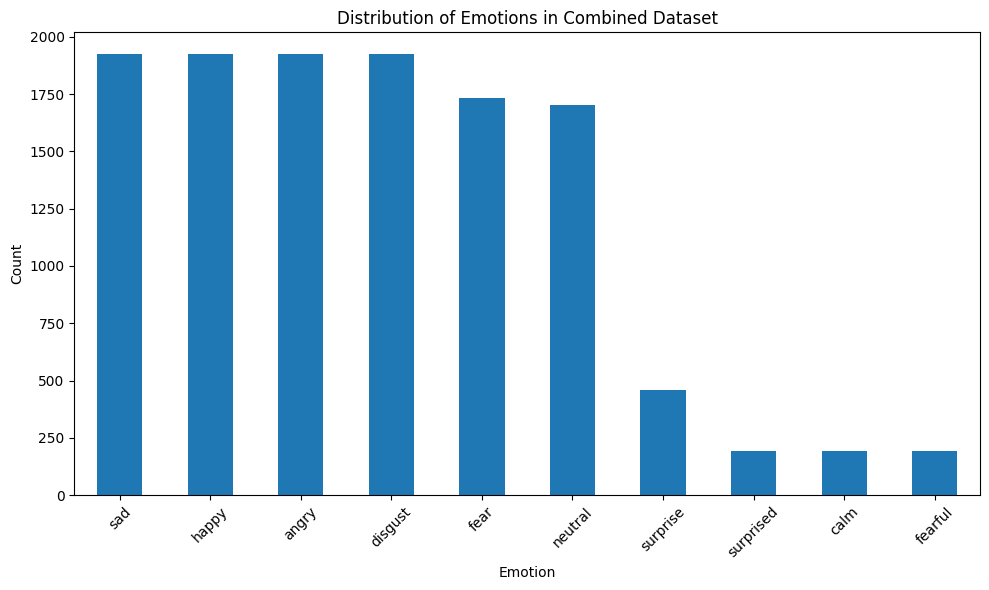

In [ ]:
# Plot the chart
plt.figure(figsize=(10, 6))
combined_df['Emotion'].value_counts().plot(kind='bar')
plt.title('Distribution of Emotions in Combined Dataset')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()



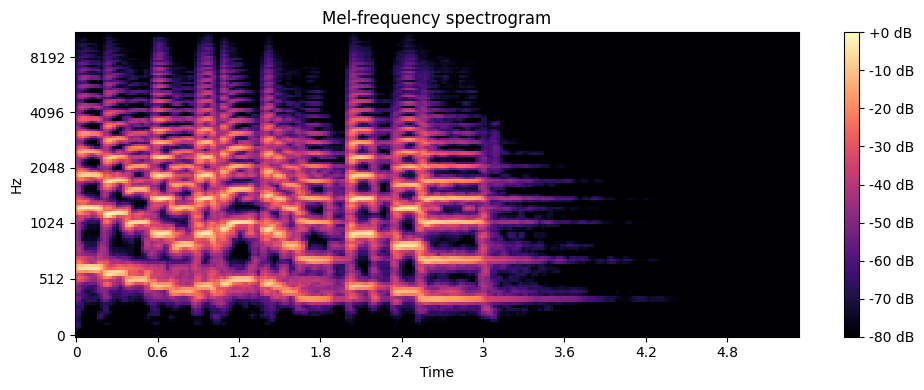

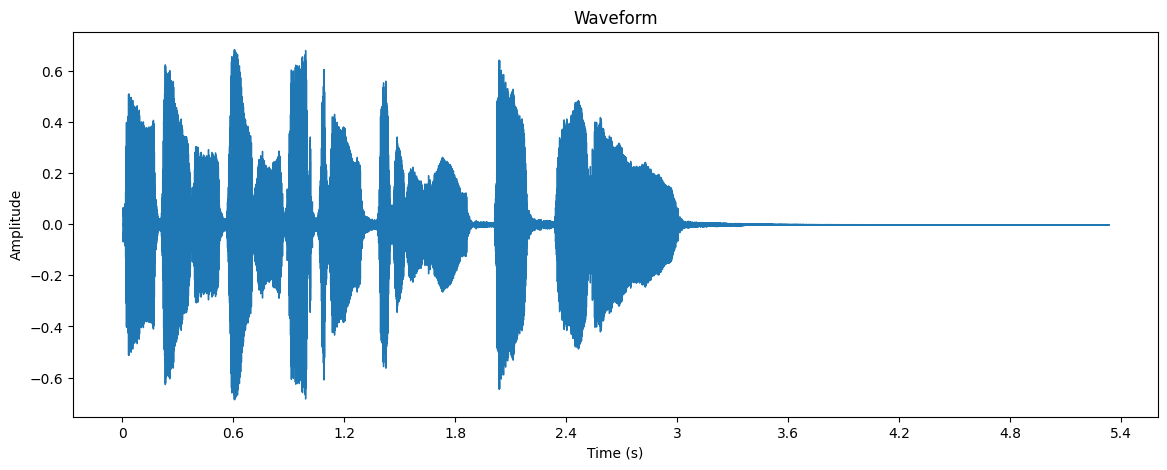

In [ ]:
# Load an example audio file
audio_path = librosa.example('trumpet')
y, sr = librosa.load(audio_path)

# Compute the spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr)
S_dB = librosa.power_to_db(S, ref=np.max)

# Display the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

# Plot the waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

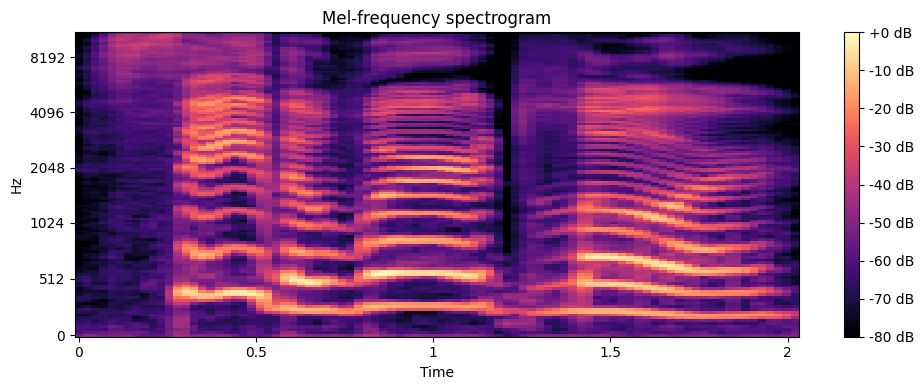

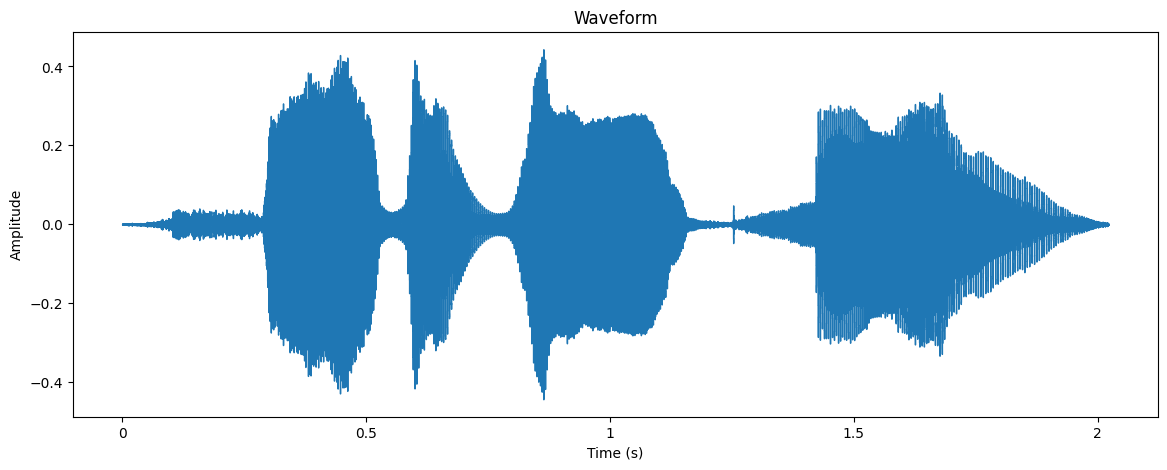

In [ ]:

# Assuming combined_df is already created as in the previous steps

# Filter the DataFrame for a specific emotion, e.g., 'happy'
emotion = 'happy'
filtered_df = combined_df[combined_df['Emotion'] == emotion]

# Select a single example (you can choose a specific index or use .sample() for a random example)
example = filtered_df.sample(1).iloc[0]  # Random example
# example = filtered_df.iloc[0]  # First example

# Save the file path to audio_path
audio_path = example['FilePath']

# Load the audio file
y, sr = librosa.load(audio_path)

# Compute the spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr)
S_dB = librosa.power_to_db(S, ref=np.max)

# Display the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

# Plot the waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

Audio(audio_path)


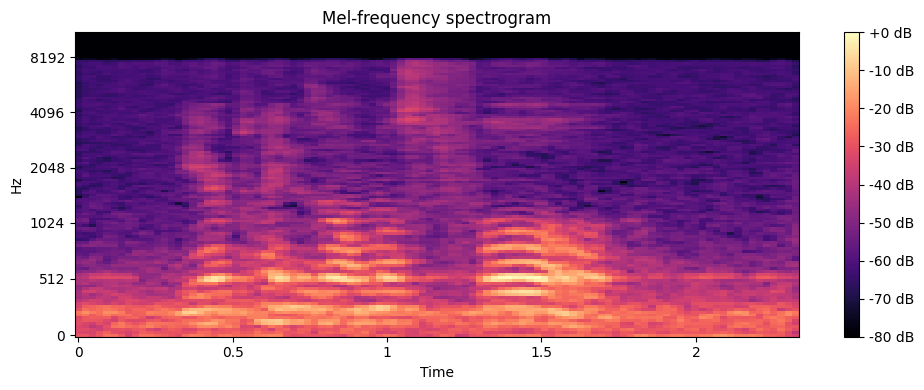

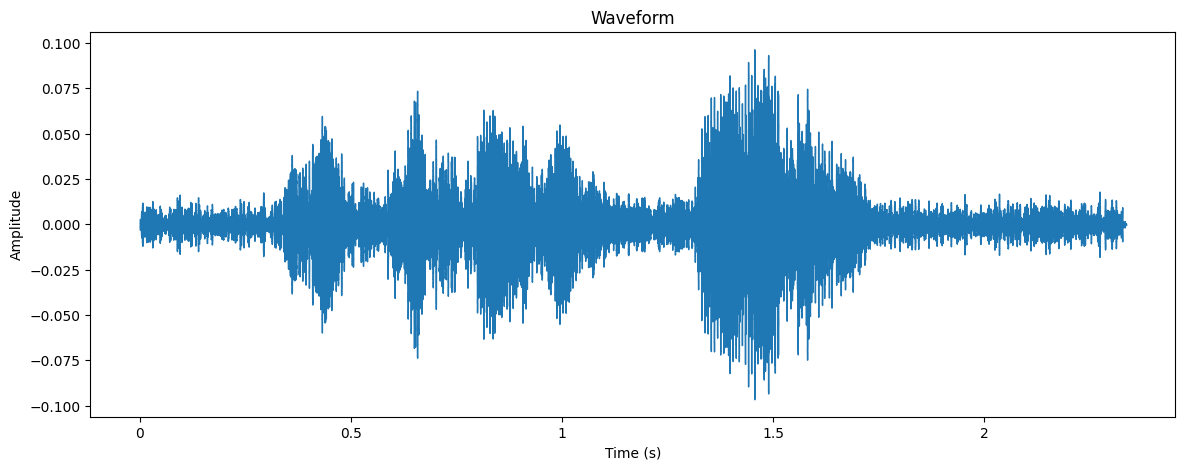

In [ ]:

# Assuming combined_df is already created as in the previous steps

# Filter the DataFrame for a specific emotion, e.g., 'happy'
emotion = 'sad'
filtered_df = combined_df[combined_df['Emotion'] == emotion]

# Select a single example (you can choose a specific index or use .sample() for a random example)
example = filtered_df.sample(1).iloc[0]  # Random example
# example = filtered_df.iloc[0]  # First example

# Save the file path to audio_path
audio_path = example['FilePath']

# Load the audio file
y, sr = librosa.load(audio_path)

# Compute the spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr)
S_dB = librosa.power_to_db(S, ref=np.max)

# Display the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

# Plot the waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

Audio(audio_path)


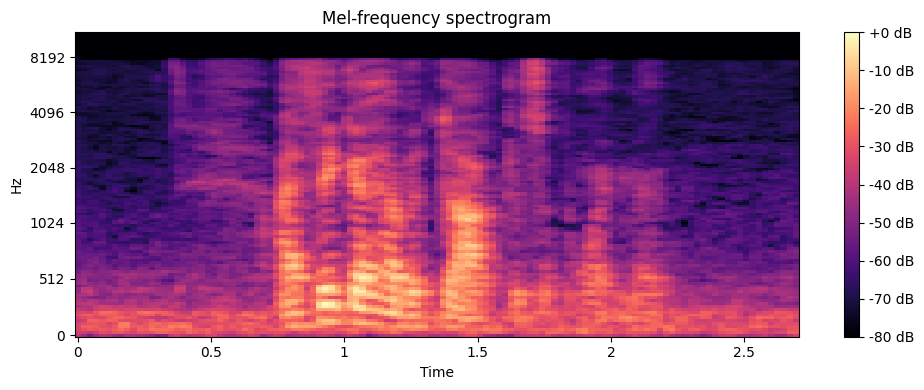

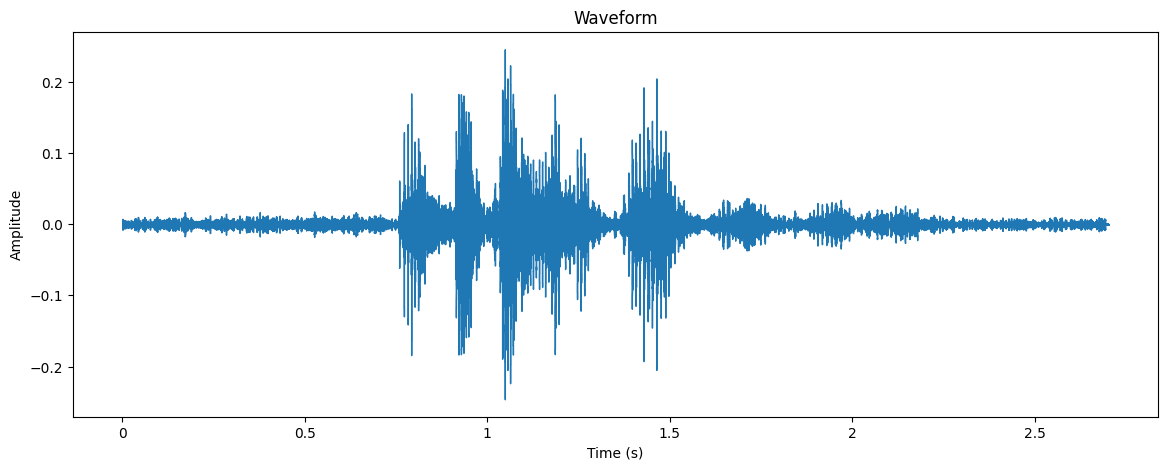

In [ ]:

# Assuming combined_df is already created as in the previous steps

# Filter the DataFrame for a specific emotion, e.g., 'happy'
emotion = 'angry'
filtered_df = combined_df[combined_df['Emotion'] == emotion]

# Select a single example (you can choose a specific index or use .sample() for a random example)
example = filtered_df.sample(1).iloc[0]  # Random example
# example = filtered_df.iloc[0]  # First example

# Save the file path to audio_path
audio_path = example['FilePath']

# Load the audio file
y, sr = librosa.load(audio_path)

# Compute the spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr)
S_dB = librosa.power_to_db(S, ref=np.max)

# Display the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

# Plot the waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

Audio(audio_path)


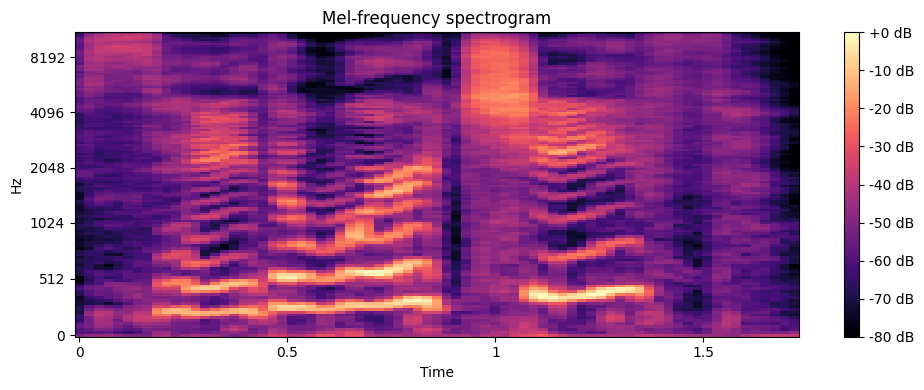

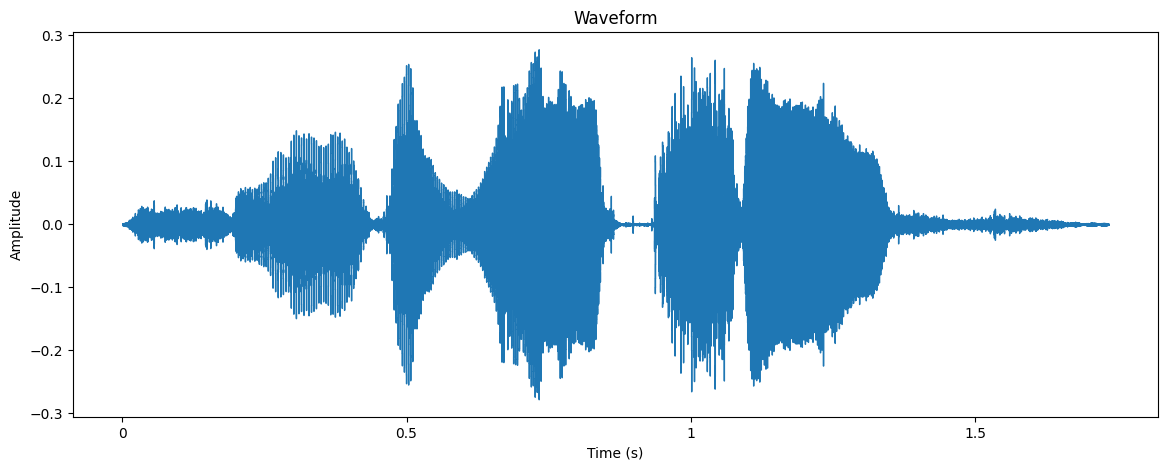

In [ ]:

# Assuming combined_df is already created as in the previous steps

# Filter the DataFrame for a specific emotion, e.g., 'happy'
emotion = 'fear'
filtered_df = combined_df[combined_df['Emotion'] == emotion]

# Select a single example (you can choose a specific index or use .sample() for a random example)
example = filtered_df.sample(1).iloc[0]  # Random example
# example = filtered_df.iloc[0]  # First example

# Save the file path to audio_path
audio_path = example['FilePath']

# Load the audio file
y, sr = librosa.load(audio_path)

# Compute the spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr)
S_dB = librosa.power_to_db(S, ref=np.max)

# Display the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

# Plot the waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

Audio(audio_path)


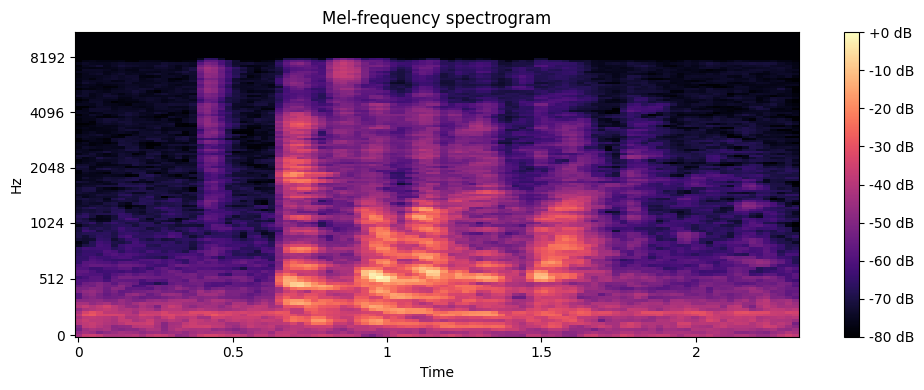

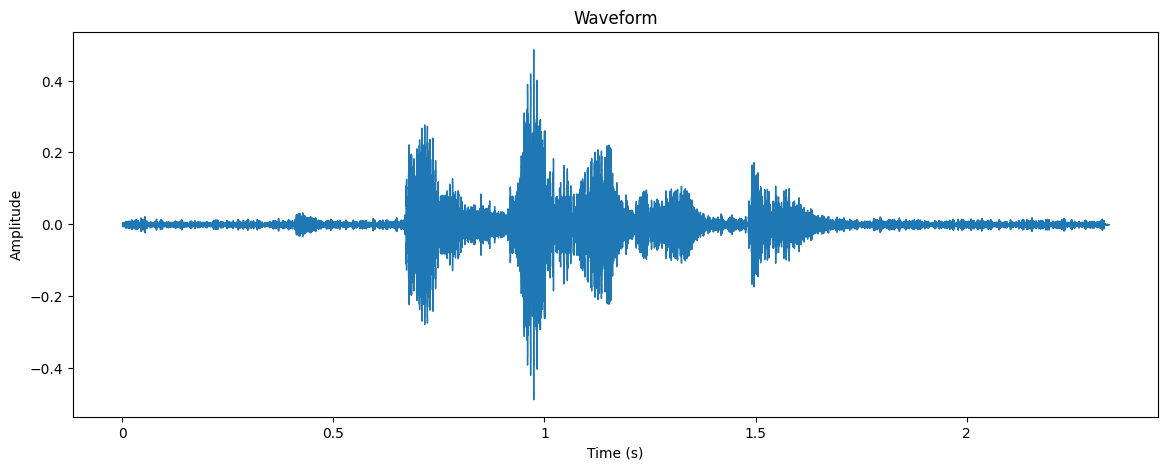

In [ ]:

# Assuming combined_df is already created as in the previous steps

# Filter the DataFrame for a specific emotion, e.g., 'happy'
emotion = 'disgust'
filtered_df = combined_df[combined_df['Emotion'] == emotion]

# Select a single example (you can choose a specific index or use .sample() for a random example)
example = filtered_df.sample(1).iloc[0]  # Random example
# example = filtered_df.iloc[0]  # First example

# Save the file path to audio_path
audio_path = example['FilePath']

# Load the audio file
y, sr = librosa.load(audio_path)

# Compute the spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr)
S_dB = librosa.power_to_db(S, ref=np.max)

# Display the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

# Plot the waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

Audio(audio_path)


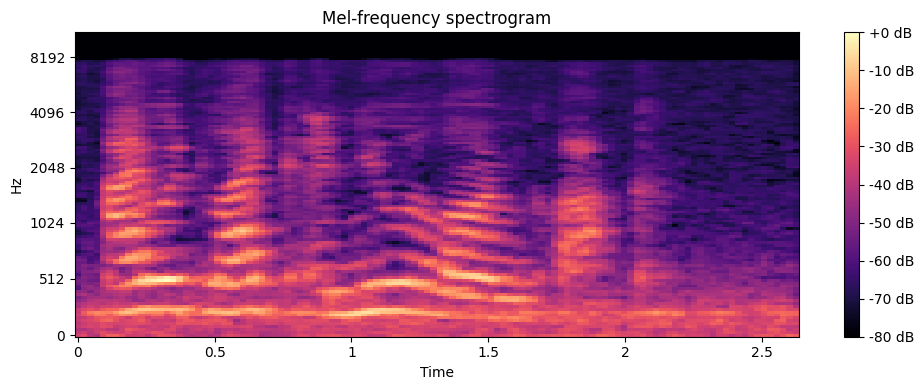

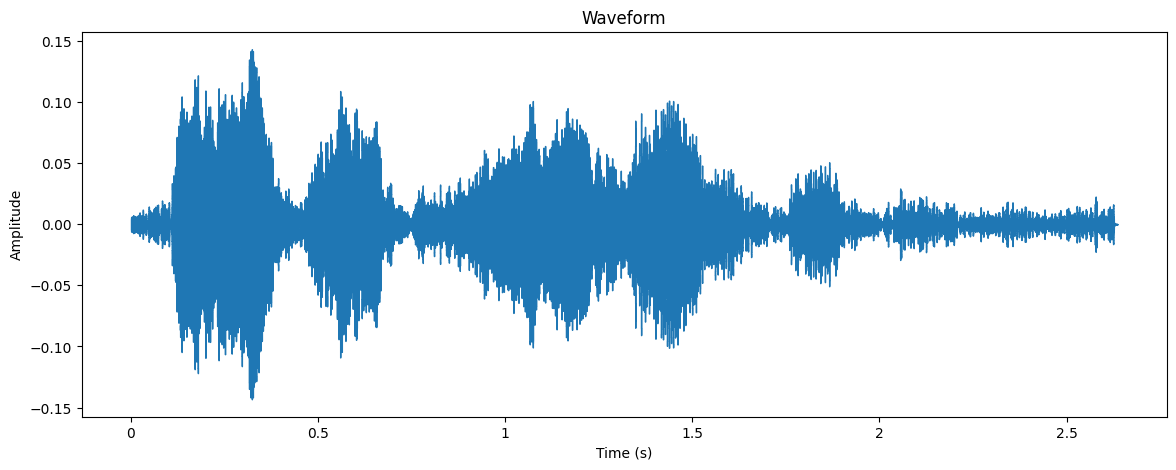

In [ ]:

# Assuming combined_df is already created as in the previous steps

# Filter the DataFrame for a specific emotion, e.g., 'happy'
emotion = 'neutral'
filtered_df = combined_df[combined_df['Emotion'] == emotion]

# Select a single example (you can choose a specific index or use .sample() for a random example)
example = filtered_df.sample(1).iloc[0]  # Random example
# example = filtered_df.iloc[0]  # First example

# Save the file path to audio_path
audio_path = example['FilePath']

# Load the audio file
y, sr = librosa.load(audio_path)

# Compute the spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr)
S_dB = librosa.power_to_db(S, ref=np.max)

# Display the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

# Plot the waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

Audio(audio_path)


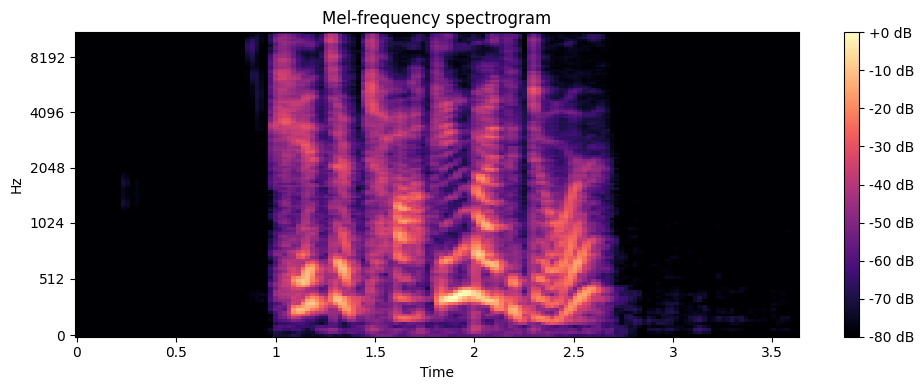

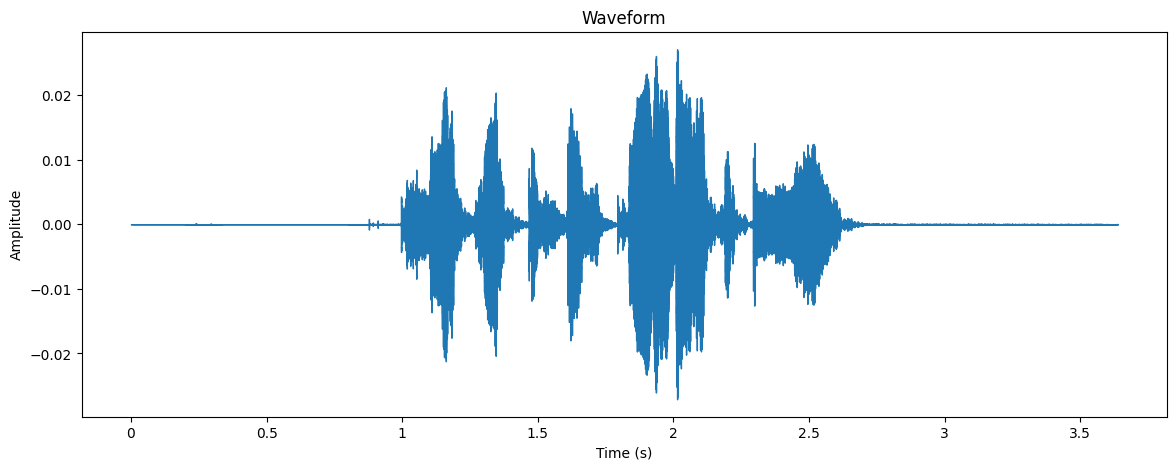

In [ ]:

# Assuming combined_df is already created as in the previous steps

# Filter the DataFrame for a specific emotion, e.g., 'happy'
emotion = 'surprised'
filtered_df = combined_df[combined_df['Emotion'] == emotion]

# Select a single example (you can choose a specific index or use .sample() for a random example)
example = filtered_df.sample(1).iloc[0]  # Random example
# example = filtered_df.iloc[0]  # First example

# Save the file path to audio_path
audio_path = example['FilePath']

# Load the audio file
y, sr = librosa.load(audio_path)

# Compute the spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr)
S_dB = librosa.power_to_db(S, ref=np.max)

# Display the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

# Plot the waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

Audio(audio_path)


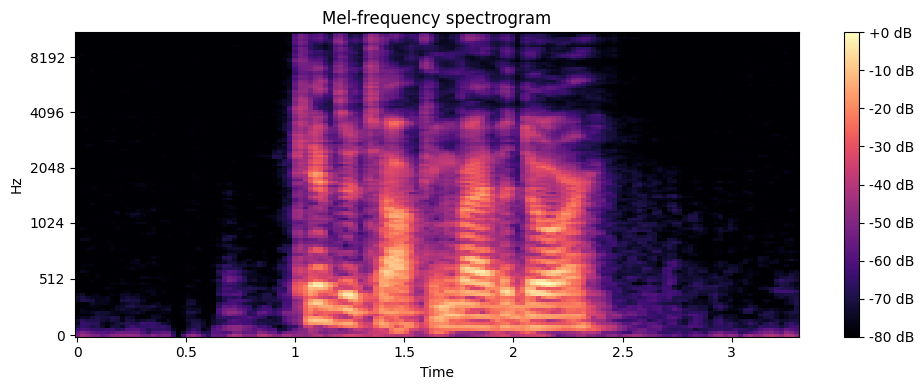

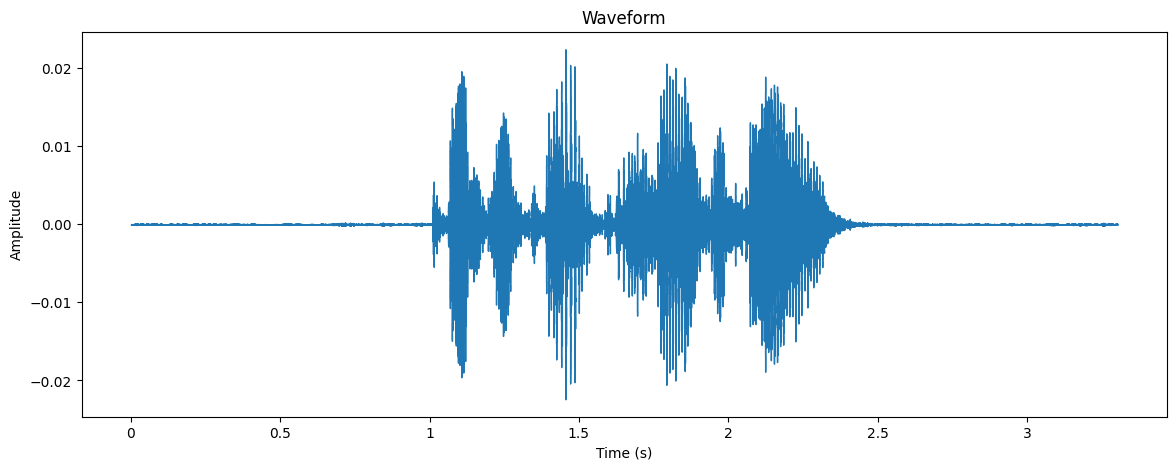

In [ ]:

# Assuming combined_df is already created as in the previous steps

# Filter the DataFrame for a specific emotion, e.g., 'happy'
emotion = 'calm'
filtered_df = combined_df[combined_df['Emotion'] == emotion]

# Select a single example (you can choose a specific index or use .sample() for a random example)
example = filtered_df.sample(1).iloc[0]  # Random example
# example = filtered_df.iloc[0]  # First example

# Save the file path to audio_path
audio_path = example['FilePath']

# Load the audio file
y, sr = librosa.load(audio_path)

# Compute the spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr)
S_dB = librosa.power_to_db(S, ref=np.max)

# Display the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

# Plot the waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

Audio(audio_path)


In [ ]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import random
import soundfile as sf

# Ensure the output directory exists
def create_directory(path):
    if not os.path.exists(path):
        os.makedirs(path)

# Function to apply augmentations and save the augmented file
def augment_and_save(y, sr, file_path, label, aug_type, aug_dir='augmented_data'):
    # Create the necessary directories
    create_directory(aug_dir)
    create_directory(os.path.join(aug_dir, label))

    # Apply augmentations
    if aug_type == 'time_stretch':
        y_aug = librosa.effects.time_stretch(y, rate=0.8)  # Slow down
    elif aug_type == 'pitch_shift':
        y_aug = librosa.effects.pitch_shift(y, sr=sr, n_steps=4)  # Shift up by 4 semitones
    elif aug_type == 'add_noise':
        y_aug = y + 0.005 * np.random.randn(len(y))  # Add noise
    elif aug_type == 'time_shift':
        shift = int(0.2 * sr)  # Shift by 0.2 seconds
        y_aug = np.roll(y, shift)
    else:
        y_aug = y  # No augmentation

    # Construct new file path
    base, ext = os.path.splitext(os.path.basename(file_path))
    new_file_path = os.path.join(aug_dir, label, f"{base}_{aug_type}{ext}")

    # Save the augmented file using soundfile
    sf.write(new_file_path, y_aug, sr)

# Directory to save augmented data
augmented_dir = 'augmented_data'

# Set seed for reproducibility
random.seed(42)

# List of augmentations to apply
augmentations = ['time_stretch', 'pitch_shift', 'add_noise', 'time_shift']

# Process each label
for label in combined_df['Emotion'].unique():
    label_df = combined_df[combined_df['Emotion'] == label]
    num_files = len(label_df)
    num_augmented = max(1, int(0.05 * num_files))  # 5% of files, at least 1 file

    # Select random files for augmentation
    sampled_files = label_df.sample(num_augmented, random_state=42)

    for _, row in sampled_files.iterrows():
        file_path = row['FilePath']
        y, sr = librosa.load(file_path)

        # Apply all augmentations
        for aug_type in augmentations:
            augment_and_save(y, sr, file_path, label, aug_type, aug_dir=augmented_dir)

print(f"Augmentation completed. Augmented files are saved in '{augmented_dir}' directory.")


Augmentation completed. Augmented files are saved in 'augmented_data' directory.


In [ ]:
import glob

# Function to create a DataFrame from the augmented files
def create_augmented_df(augmented_dir):
    augmented_data = []

    for label in os.listdir(augmented_dir):
        label_dir = os.path.join(augmented_dir, label)
        if os.path.isdir(label_dir):
            for file in glob.glob(os.path.join(label_dir, '*.wav')):
                augmented_data.append((label, file))

    return pd.DataFrame(augmented_data, columns=['Emotion', 'FilePath'])

# Create a DataFrame for the augmented data
augmented_df = create_augmented_df(augmented_dir)

# Concatenate the original DataFrame with the augmented DataFrame
final_df = pd.concat([combined_df, augmented_df], ignore_index=True)

# Save the concatenated DataFrame to a CSV file
final_df.to_csv('final_dataset.csv', index=False)

print(f"Concatenation completed. Final dataset is saved as 'final_dataset.csv'.")


Concatenation completed. Final dataset is saved as 'final_dataset.csv'.


In [ ]:
df_csv = pd.read_csv('final_dataset.csv') # Read the csv file into a DataFrame
print(df_csv) # Now you can call .head() on the DataFrame object

       Emotion                                           FilePath
0          sad  /kaggle/input/cremad/AudioWAV/1039_ITS_SAD_XX.wav
1         fear  /kaggle/input/cremad/AudioWAV/1070_TAI_FEA_XX.wav
2         fear  /kaggle/input/cremad/AudioWAV/1019_WSI_FEA_XX.wav
3        happy  /kaggle/input/cremad/AudioWAV/1036_TAI_HAP_XX.wav
4        angry  /kaggle/input/cremad/AudioWAV/1087_IWW_ANG_XX.wav
...        ...                                                ...
14577  neutral  augmented_data/neutral/1018_TAI_NEU_XX_pitch_s...
14578  neutral  augmented_data/neutral/1029_TSI_NEU_XX_pitch_s...
14579  neutral  augmented_data/neutral/1048_TSI_NEU_XX_add_noi...
14580  neutral  augmented_data/neutral/1065_TIE_NEU_XX_pitch_s...
14581  neutral       augmented_data/neutral/DC_n14_time_shift.wav

[14582 rows x 2 columns]


In [ ]:
import pandas as pd
import numpy as np
import librosa

# Load the CSV file containing emotion labels and file paths
csv_path = '/content/final_dataset.csv'
data = pd.read_csv(csv_path)

# Initialize lists to store features
mfccs = []
chroma = []
mel_spectrogram = []
spectral_centroids = []
spectral_rolloff = []
zero_crossing_rate = []
energy_entropy = []
spectral_flux = []
labels = []

# Iterate through the audio files in the CSV file
for index, row in data.iterrows():
    file_path = row['FilePath']
    label = row['Emotion']

    # Load audio file
    y, sr = librosa.load(file_path)

    # Calculate features
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)
    chroma_feat = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
    mel_spec = np.mean(librosa.feature.melspectrogram(y=y, sr=sr).T, axis=0)
    spec_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr).T, axis=0)
    spec_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr).T, axis=0)
    zcr = np.mean(librosa.feature.zero_crossing_rate(y).T, axis=0)
    energy_ent = np.mean(librosa.feature.spectral_flatness(y=y).T, axis=0)
    spec_flux = np.mean(librosa.onset.onset_strength(y=y, sr=sr).T, axis=0)

    # Append features and label to the lists
    mfccs.append(mfcc)
    chroma.append(chroma_feat)
    mel_spectrogram.append(mel_spec)
    spectral_centroids.append(spec_centroid)
    spectral_rolloff.append(spec_rolloff)
    zero_crossing_rate.append(zcr)
    energy_entropy.append(energy_ent)
    spectral_flux.append(spec_flux)
    labels.append(label)

# Create a DataFrame to store the features and labels
features_data = pd.DataFrame({
    'MFCCs': mfccs,
    'Chroma': chroma,
    'Mel Spectrogram': mel_spectrogram,
    'Spectral Centroid': spectral_centroids,
    'Spectral Rolloff': spectral_rolloff,
    'Zero Crossing Rate': zero_crossing_rate,
    'Energy Entropy': energy_entropy,
    'Spectral Flux': spectral_flux,
    'Label': labels
})

# Save the DataFrame to a new CSV file
features_data.to_csv('audio_features.csv', index=False)


/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [ ]:
main_csv = pd.read_csv('audio_features.csv')
main_csv.head()

,MFCCs,Chroma,Mel Spectrogram,Spectral Centroid,Spectral Rolloff,Zero Crossing Rate,Energy Entropy,Spectral Flux,Label
0,[-446.5156 140.40033 13.965074 75.3...,[0.4075666 0.35940835 0.2663666 0.22902395 0...,[6.5979719e-02 4.3450143e-02 8.0566995e-02 1.9...,[1325.26596278],[2962.13764391],[0.05316698],[0.0002161],1.041272,sad
1,[-341.1119 132.4301 20.538685 41.7...,[0.46027148 0.4394727 0.35517606 0.26711926 0...,[7.60215074e-02 4.29154076e-02 5.77849187e-02 ...,[1412.92043996],[2835.85759943],[0.07343454],[0.00017031],1.475641,fear
2,[-404.6044 135.50508 11.91465 61.1...,[0.30358204 0.32530507 0.28416032 0.3704888 0...,[1.16080768e-01 4.41559255e-02 4.58814912e-02 ...,[1449.4252245],[2919.68895165],[0.07192251],[0.00024392],1.355498,fear
3,[-335.7508 123.4589 26.888218 44.4...,[0.37203696 0.29835084 0.263229 0.39355537 0...,[7.94325098e-02 3.84964831e-02 6.27144352e-02 ...,[1322.33789682],[2899.8046875],[0.05384599],[0.00017539],1.476379,happy
4,[-4.1265903e+02 1.3339720e+02 2.2159569e+01 ...,[0.31747147 0.32980773 0.3102734 0.35253796 0...,[5.91342896e-03 1.20164096e-01 3.41083378e-01 ...,[1243.84584122],[2345.63107374],[0.05741473],[0.00018929],1.534585,angry


In [ ]:
main_csv['MFCCs'].head(3)

0    [-446.5156     140.40033     13.965074    75.3...
1    [-341.1119     132.4301      20.538685    41.7...
2    [-404.6044     135.50508     11.91465     61.1...
Name: MFCCs, dtype: object

In [ ]:
# Convert the 'MFCCs' column from string representation to actual numpy arrays
main_csv['MFCCs'] = main_csv['MFCCs'].apply(lambda x: np.fromstring(x[1:-1], dtype=float, sep=' '))

# Now calculate the mean of MFCCs for each row (audio file)
main_csv['Mean MFCCs'] = main_csv['MFCCs'].apply(lambda x: np.mean(x))

# Display the first few rows of the DataFrame with the mean MFCCs
print(main_csv['Mean MFCCs'].head())

0   -16.954142
1   -14.341301
2   -15.733161
3   -14.266241
4   -16.409648
Name: Mean MFCCs, dtype: float64


In [ ]:
# Convert the 'chroma' column from string representation to actual numpy arrays
main_csv['Chroma'] = main_csv['Chroma'].apply(lambda x: np.fromstring(x[1:-1], dtype=float, sep=' '))

# Now calculate the mean of chroma for each row (audio file)
main_csv['Mean Chroma'] = main_csv['Chroma'].apply(lambda x: np.mean(x))

# Display the first few rows of the DataFrame with the mean chroma
print(main_csv['Mean Chroma'].head())

0    0.416180
1    0.392807
2    0.371618
3    0.385767
4    0.413331
Name: Mean Chroma, dtype: float64


In [ ]:
# Convert the 'Mel Spectrogram' column from string representation to actual numpy arrays
main_csv['Mel Spectrogram'] = main_csv['Mel Spectrogram'].apply(lambda x: np.fromstring(x[1:-1], dtype=float, sep=' '))

# Now calculate the mean of Mel Spectrogram for each row (audio file)
main_csv['Mean Mel Spectrogram'] = main_csv['Mel Spectrogram'].apply(lambda x: np.mean(x))

# Display the first few rows of the DataFrame with the mean Mel Spectrogram
print(main_csv['Mean Mel Spectrogram'].head())

0    0.019826
1    0.725567
2    0.080996
3    1.525476
4    0.142628
Name: Mean Mel Spectrogram, dtype: float64


In [ ]:
main_csv = main_csv.drop('MFCCs', axis=1)  # Drop the 'MFCCs' column

In [ ]:
main_csv = main_csv.drop('Chroma', axis=1)  # Drop the 'MFCCs' column

In [ ]:
main_csv = main_csv.drop('Mel Spectrogram', axis=1)  # Drop the 'MFCCs' column

In [ ]:
main_csv.head()

,Spectral Centroid,Spectral Rolloff,Zero Crossing Rate,Energy Entropy,Spectral Flux,Label,Mean MFCCs,Mean Chroma,Mean Mel Spectrogram
0,[1325.26596278],[2962.13764391],[0.05316698],[0.0002161],1.041272,sad,-16.954142,0.416180,0.019826
1,[1412.92043996],[2835.85759943],[0.07343454],[0.00017031],1.475641,fear,-14.341301,0.392807,0.725567
2,[1449.4252245],[2919.68895165],[0.07192251],[0.00024392],1.355498,fear,-15.733161,0.371618,0.080996
3,[1322.33789682],[2899.8046875],[0.05384599],[0.00017539],1.476379,happy,-14.266241,0.385767,1.525476
4,[1243.84584122],[2345.63107374],[0.05741473],[0.00018929],1.534585,angry,-16.409648,0.413331,0.142628


In [ ]:
# Move the 'label' column to the last column
label_col = main_csv.pop('Label')
main_csv['Label'] = label_col

# Save the modified DataFrame to a new CSV file
main_csv.to_csv('new_main_csv.csv', index=False)

In [ ]:
new_main_csv = pd.read_csv('new_main_csv.csv')
new_main_csv.head()

,Spectral Centroid,Spectral Rolloff,Zero Crossing Rate,Energy Entropy,Spectral Flux,Mean MFCCs,Mean Chroma,Mean Mel Spectrogram,Label
0,[1325.26596278],[2962.13764391],[0.05316698],[0.0002161],1.041272,-16.954142,0.416180,0.019826,sad
1,[1412.92043996],[2835.85759943],[0.07343454],[0.00017031],1.475641,-14.341301,0.392807,0.725567,fear
2,[1449.4252245],[2919.68895165],[0.07192251],[0.00024392],1.355498,-15.733161,0.371618,0.080996,fear
3,[1322.33789682],[2899.8046875],[0.05384599],[0.00017539],1.476379,-14.266241,0.385767,1.525476,happy
4,[1243.84584122],[2345.63107374],[0.05741473],[0.00018929],1.534585,-16.409648,0.413331,0.142628,angry


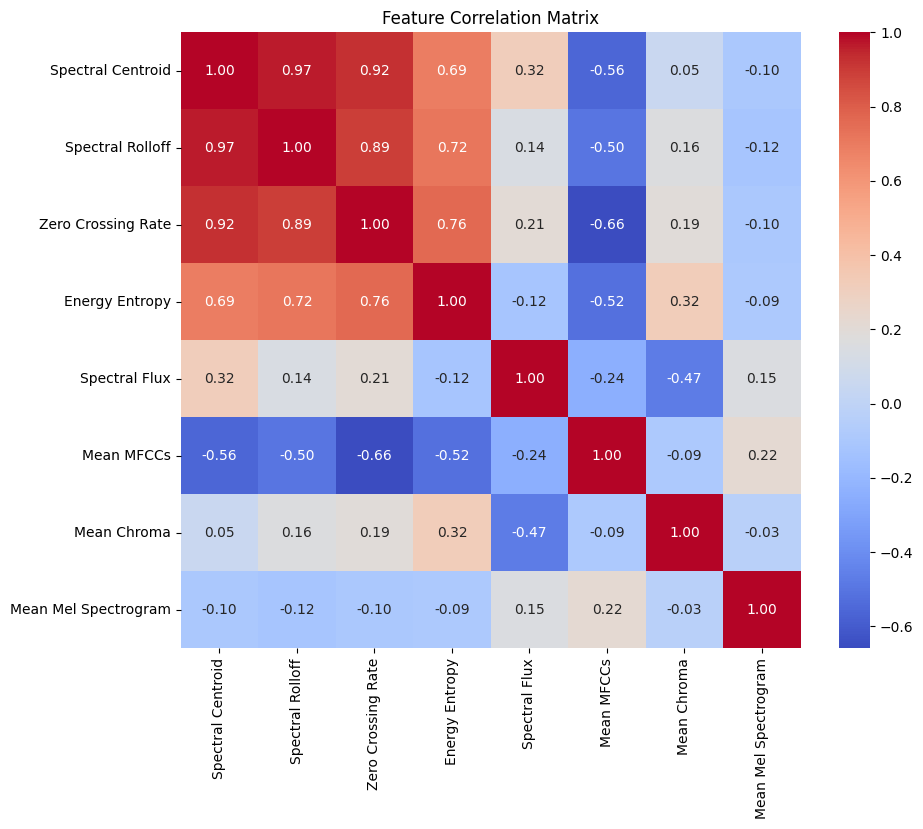

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load the CSV file
file_path = '/content/new_main_csv.csv'
data = pd.read_csv(file_path)

# Convert the string representations of lists to numeric values
for col in data.columns[:-1]:  # Exclude the Label column
    # Check if the column contains string representations of lists
    if data[col].dtype == 'object':
        data[col] = data[col].apply(lambda x: float(x.strip('[]')) if x.strip('[]') else np.nan)

# Handle potential missing values
data = data.dropna()

# Compute the correlation matrix, excluding the label column
numeric_data = data.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()


In [ ]:
new_main_csv = new_main_csv.drop('Spectral Rolloff', axis=1)

In [ ]:
new_main_csv = new_main_csv.drop('Zero Crossing Rate', axis=1)

In [ ]:
new_main_csv.head()

,Spectral Centroid,Energy Entropy,Spectral Flux,Mean MFCCs,Mean Chroma,Mean Mel Spectrogram,Label
0,[1325.26596278],[0.0002161],1.041272,-16.954142,0.416180,0.019826,sad
1,[1412.92043996],[0.00017031],1.475641,-14.341301,0.392807,0.725567,fear
2,[1449.4252245],[0.00024392],1.355498,-15.733161,0.371618,0.080996,fear
3,[1322.33789682],[0.00017539],1.476379,-14.266241,0.385767,1.525476,happy
4,[1243.84584122],[0.00018929],1.534585,-16.409648,0.413331,0.142628,angry


In [ ]:
import pandas as pd

# Load the CSV file  # Replace with your actual file path
data = new_main_csv

# Convert the string representations of lists to numeric values
for col in data.columns[:-1]:  # Exclude the Label column
    if data[col].dtype == 'object':
        data[col] = data[col].apply(lambda x: float(x.strip('[]')) if x.strip('[]') else None)

# Handle potential missing values by removing rows with any NaN values
data = data.dropna()

# Save the modified data back to a new CSV file
new_file_path = 'modified_csv_file.csv'
data.to_csv(new_file_path, index=False)

print(f'Modified CSV file saved to {new_file_path}')


Modified CSV file saved to modified_csv_file.csv


In [ ]:
new_file_path = 'modified_csv_file.csv'
new_file_path_data = pd.read_csv(new_file_path)
new_file_path_data.head()

,Spectral Centroid,Energy Entropy,Spectral Flux,Mean MFCCs,Mean Chroma,Mean Mel Spectrogram,Label
0,1325.265963,0.000216,1.041272,-16.954142,0.416180,0.019826,sad
1,1412.920440,0.000170,1.475641,-14.341301,0.392807,0.725567,fear
2,1449.425225,0.000244,1.355498,-15.733161,0.371618,0.080996,fear
3,1322.337897,0.000175,1.476379,-14.266241,0.385767,1.525476,happy
4,1243.845841,0.000189,1.534585,-16.409648,0.413331,0.142628,angry


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the CSV file
file_path = 'modified_csv_file.csv'  # Replace with your actual modified file path
data = pd.read_csv(file_path)

# Separate the features and the label
features = data.drop(columns=['Label'])  # Exclude the label column
labels = data['Label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler (do not fit again)
X_test_scaled = scaler.transform(X_test)

# Combine the normalized training data and labels into a DataFrame
train_data = pd.DataFrame(X_train_scaled, columns=features.columns)
train_data['Label'] = y_train.values

# Combine the normalized testing data and labels into a DataFrame
test_data = pd.DataFrame(X_test_scaled, columns=features.columns)
test_data['Label'] = y_test.values

# Save the normalized training and testing data to new CSV files
train_file_path = 'normalized_train_csv_file.csv'
test_file_path = 'normalized_test_csv_file.csv'
train_data.to_csv(train_file_path, index=False)
test_data.to_csv(test_file_path, index=False)

print(f'Normalized training data saved to {train_file_path}')
print(f'Normalized testing data saved to {test_file_path}')


Normalized training data saved to normalized_train_csv_file.csv
Normalized testing data saved to normalized_test_csv_file.csv


In [ ]:
train_data_new = pd.read_csv('normalized_train_csv_file.csv')
train_data_new.head()

,Spectral Centroid,Energy Entropy,Spectral Flux,Mean MFCCs,Mean Chroma,Mean Mel Spectrogram,Label
0,-0.836572,-0.427879,-0.598993,0.645278,0.729592,-0.316031,sad
1,-0.596318,-0.427241,-0.051766,0.338260,0.563621,-0.335176,disgust
2,-0.827194,-0.417099,-1.425548,0.308182,0.037986,-0.338805,sad
3,-0.621202,-0.416257,-0.294467,0.719991,0.220277,-0.218326,disgust
4,-0.570737,-0.427127,-0.336367,0.852854,0.911108,-0.164462,disgust


In [ ]:
train_data_new.shape

(11665, 7)

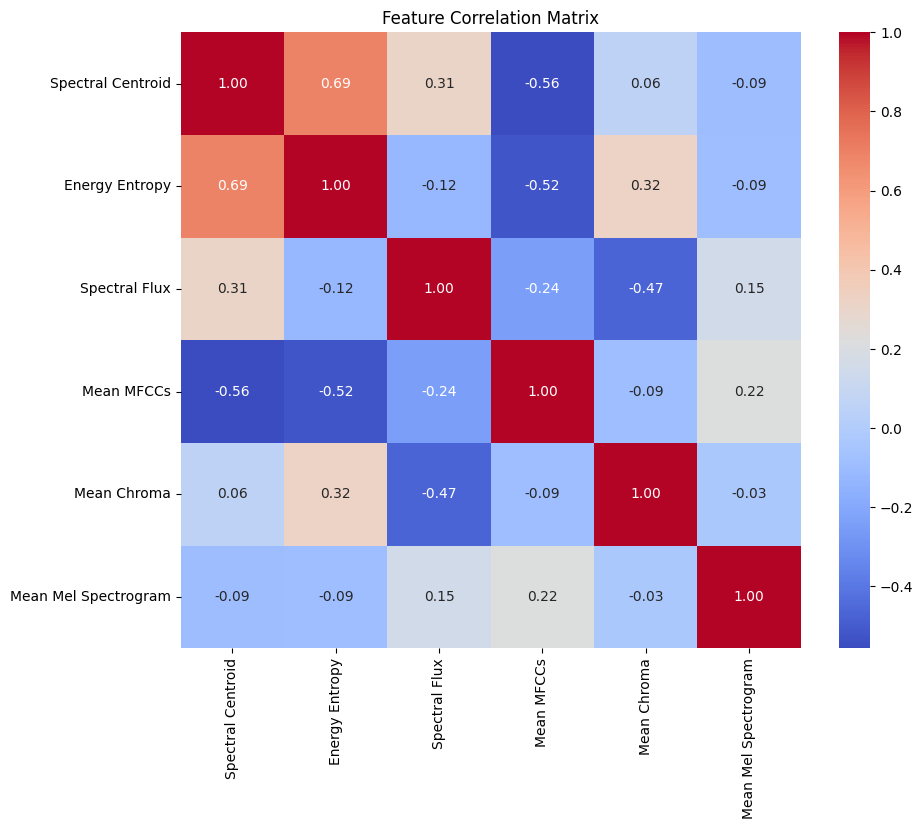

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load the CSV file
file_path = 'normalized_train_csv_file.csv'
data = pd.read_csv(file_path)

# Convert the string representations of lists to numeric values
for col in data.columns[:-1]:  # Exclude the Label column
    # Check if the column contains string representations of lists
    if data[col].dtype == 'object':
        data[col] = data[col].apply(lambda x: float(x.strip('[]')) if x.strip('[]') else np.nan)

# Handle potential missing values
data = data.dropna()

# Compute the correlation matrix, excluding the label column
numeric_data = data.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

In [ ]:
test_data_new = pd.read_csv('normalized_test_csv_file.csv')
test_data_new.head()

,Spectral Centroid,Energy Entropy,Spectral Flux,Mean MFCCs,Mean Chroma,Mean Mel Spectrogram,Label
0,-0.054361,-0.147384,1.321544,-0.793296,-1.526179,-0.287105,disgust
1,-1.577419,-0.431192,0.809045,0.601769,1.640341,0.047192,neutral
2,-0.499064,-0.426390,-0.412605,0.777930,0.433989,-0.224508,disgust
3,1.147516,0.250351,1.364986,-0.909520,-1.375222,-0.277610,fear
4,-0.552544,-0.426053,0.010168,0.697422,-0.504436,-0.271164,happy


In [ ]:
test_data_new.shape

(2917, 7)

In [ ]:
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, Add, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization, Dropout, LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.regularizers import l2


# Sample data provided
data = pd.read_csv('normalized_train_csv_file.csv')

# Separate features and labels
normalized_features = data.iloc[:, :-1]
labels = data.iloc[:, -1]

# Convert DataFrame to NumPy array before reshaping
normalized_features_array = normalized_features.values

# Reshape data for Conv1D
input_data = normalized_features_array.reshape((normalized_features_array.shape[0], normalized_features_array.shape[1], 1))

# Encode the labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
categorical_labels = to_categorical(encoded_labels)

# Display shapes for confirmation
print(f'Input data shape: {input_data.shape}')  # Should be (samples, features, 1)
print(f'Labels shape: {categorical_labels.shape}')  # Number of classes


model=Sequential()
model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(input_data.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(categorical_labels.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Input data shape: (11665, 6, 1)
Labels shape: (11665, 10)


In [ ]:
from tensorflow.keras.optimizers import Adam

# Custom Adam optimizer
#custom_adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)

# Compile the model with the custom optimizer
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#from keras.callbacks import ReduceLROnPlateau
#rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
#history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_35 (Conv1D)          (None, 6, 512)            3072      
                                                                 
 max_pooling1d_20 (MaxPooli  (None, 3, 512)            0         
 ng1D)                                                           
                                                                 
 conv1d_36 (Conv1D)          (None, 3, 256)            655616    
                                                                 
 batch_normalization_18 (Ba  (None, 3, 256)            1024      
 tchNormalization)                                               
                                                                 
 max_pooling1d_21 (MaxPooli  (None, 2, 256)            0         
 ng1D)                                                           
                                                      

In [ ]:
# Assuming you have separate validation data
validation_features = test_data_new.iloc[:, :-1]  # Your validation features
validation_labels = test_data_new.iloc[:, -1] # Your validation labels

# Convert DataFrame to NumPy array before reshaping
validation_features_array = validation_features.values

# Reshape validation data appropriately
validation_data_reshaped = validation_features_array.reshape((validation_features_array.shape[0], validation_features_array.shape[1], 1))
validation_labels_encoded = to_categorical(label_encoder.transform(validation_labels))



In [ ]:
# Check the shape of your input data
print(input_data.shape)

# Check the input layer of your model
print(model.layers[0].input_shape)

(11665, 6, 1)
(None, 6, 1)


In [ ]:
# Fit the model with custom validation data
#history=model.fit(input_data, categorical_labels, batch_size=64, epochs=10, validation_data=(validation_data_reshaped, validation_labels_encoded), callbacks=[rlrp])
model.fit(input_data, categorical_labels, epochs=50, batch_size=32, validation_data=(validation_data_reshaped, validation_labels_encoded))

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(validation_data_reshaped,validation_labels_encoded)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test = model.predict(validation_labels_encoded)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(validation_labels_encoded)

In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)